In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
currdir = os.getcwd()
regex_name = r'(([A-Z])\w+)'
batchrun = '600s-run1'

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

## Checking out the Excel sheet

In [51]:
filename = currdir + '/experiments/sim-results/d450_ab_r1.xls'
df_tmp = pd.read_excel(filename, sheet_name='Speed').fillna(0)

In [52]:
df_tmp

,t,0x20 - approach2_lane3,0x7 - approach1_lane2,0x25 - approach1_lane1,0x19 - approach3_lane3,0x32 - approach0_lane3,0x2 - approach0_lane2,0x28 - approach1_lane3,0x17 - exit0_lane1,0x1d - approach2_lane1,...,0x29 - approach1_lane3,0x15 - exit1_lane1,0x10 - exit3_lane3,0x12 - exit2_lane3,0x13 - exit2_lane1,0x14 - exit1_lane3,0x2e - approach0_lane1,0x18 - approach3_lane3,0x2c - approach0_lane1,0x2a - approach1_lane3
0,60,18.965854,9.926012,31.023360,38.563200,52.529400,28.805166,6.868286,51.840000,29.597538,...,29.008800,51.840000,45.641739,60.480000,41.040000,53.712000,33.340235,0.000000,0.000000,44.137180
1,120,18.965854,5.423756,24.712235,35.596800,51.317731,22.548369,5.827636,63.360000,11.032774,...,27.327130,51.840000,46.656000,51.840000,47.520000,53.712000,11.808000,14.362667,1.391706,43.104414
2,180,22.007547,4.115871,17.953333,26.534312,51.800949,19.025982,6.221859,63.803077,3.599020,...,27.074880,51.840000,48.028235,45.360000,46.512000,59.680000,4.239222,8.617600,1.163315,41.209714
3,240,22.007547,3.600000,17.019085,27.859346,50.726241,14.987077,6.739344,61.144615,3.599020,...,26.940179,51.840000,47.576842,48.195000,47.424000,59.426043,4.239222,8.617600,1.038378,40.486737
4,300,12.888398,3.114354,16.399164,27.245739,49.947647,9.332521,6.214163,59.560851,2.317880,...,21.650542,54.568421,48.490787,47.421818,46.460377,56.047304,2.732587,9.694800,1.088712,39.530800
5,360,12.888398,2.386398,13.836359,24.540218,50.834903,6.380308,5.672124,58.990345,1.349669,...,21.359713,59.245714,51.503377,46.249412,49.002985,58.188000,1.280145,8.430261,1.057607,39.096396
6,420,11.269565,2.364731,13.686776,22.377099,50.345302,5.276759,5.719316,56.856774,1.055122,...,19.436382,59.245714,49.111579,45.360000,49.248000,57.604174,1.027714,7.755840,0.973631,37.879636
7,480,11.324272,2.496694,15.494464,24.822290,48.358481,4.360087,5.237255,56.089180,0.995376,...,19.411995,62.208000,46.884706,47.927547,51.300000,52.976219,0.983147,7.807893,0.983018,38.841340
8,540,12.926854,2.476426,11.958344,26.961559,49.771775,4.156585,5.327770,57.600000,1.360138,...,20.831162,57.938824,48.490787,46.777500,53.110588,53.712000,1.285685,7.271100,1.243231,39.674682
9,600,12.342857,2.376570,7.546223,30.299657,51.034809,4.350316,5.860937,58.437818,1.942183,...,24.864686,57.354894,47.469767,49.612500,54.720000,53.712000,1.756789,6.660550,1.554653,42.332830


In [53]:
# Filter out some of the rows

delay_rows = ["{} Delay".format(d) for d in range(60,601,60)]
delay_rename = dict([
    ("{} Delay".format(d), d)
    for d in range(60,601,60)
])

thru_rows = ["{} Throughput".format(d) for d in range(60,601,60)]
thru_rename = dict([
    ("{} Throughput".format(d), d)
    for d in range(60,601,60)
])

In [54]:
# Filter out some of the columns

survey_zones = df_tmp.columns.values[1:]

entrances = [x for x in survey_zones if 'approach' in x]
exits = [y for y in survey_zones if 'exit' in y]

print("{} approach zones, {} exit zones".format(len(entrances), len(exits)))

48 approach zones, 12 exit zones


In [55]:
reg_approach = re.compile('0x(\w+) - approach.*')
reg_exit = re.compile('0x(\w+) - exit.*')

entrances_rename = dict([
    (k, SURVEY_ZONE_MAPPING[reg_approach.match(k).group(1)])
    for k in entrances
])

exits_rename = dict([
    (k, SURVEY_ZONE_MAPPING[reg_exit.match(k).group(1)])
    for k in exits
])

## Obtaining cumulative delay and throughput dataframes

In [56]:
# Get the cumulative delays

df_tmp1 = df_tmp[df_tmp.t.isin(delay_rows)]
df_tmp1['t'].replace(delay_rename, inplace=True)
df_tmp1 = df_tmp1.sort_values(by='t').set_index('t')[entrances].stack().reset_index()
df_tmp1['level_1'] = df_tmp1['level_1'].map(entrances_rename)
df_tmp1 = df_tmp1.groupby(['t', 'level_1']).sum().reset_index()

df_cumdelay = df_tmp1.pivot(index='t', columns='level_1', values=0)
df_cumdelay

/home/franciszacdlc/.virtualenvs/localsim2.7/local/lib/python2.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


level_1,"(2, 0, 0)","(2, 0, 1)","(2, 0, 2)","(2, 0, 3)","(2, 1, 0)","(2, 1, 1)","(2, 1, 2)","(2, 1, 3)","(2, 2, 0)","(2, 2, 1)",...,"(3, 0, 2)","(3, 0, 3)","(3, 1, 0)","(3, 1, 1)","(3, 1, 2)","(3, 1, 3)","(3, 2, 0)","(3, 2, 1)","(3, 2, 2)","(3, 2, 3)"
t,,,,,,,,,,,,,,,,,,,,,
60,0.000000,13.355122,0.000000,42.697385,116.092692,76.277111,84.419846,20.632769,33.601372,38.565366,...,25.427561,7.655701,40.450600,24.176168,26.022289,14.083155,63.975675,44.468924,54.520146,32.190313
120,200.865517,70.170489,77.691384,92.993463,380.906665,306.624839,350.296614,62.111230,91.421239,130.696099,...,94.576618,31.668024,180.398843,86.729747,96.027111,47.885234,353.858444,214.483926,202.248928,103.025182
180,602.474711,243.511466,404.919846,168.736927,878.306151,769.521432,766.534612,214.818153,158.975354,288.102443,...,258.002357,72.447921,581.972782,199.564616,350.435491,116.134698,999.797900,534.723853,602.129983,239.163095
240,1143.205744,515.272932,871.993999,309.526468,1611.041149,1378.260394,1215.905379,568.349228,257.732212,471.824153,...,472.494213,154.677347,1067.799614,372.444385,616.932062,229.149164,1810.644342,1130.509859,1025.099228,594.206172
300,1830.430454,847.994642,1339.068153,548.710780,2691.225889,2381.140592,1764.945992,988.821689,373.723318,744.071474,...,972.934312,321.850300,1957.389306,603.693956,1169.501286,644.848478,3329.035577,2224.097943,1770.685598,1379.756537
360,2803.520682,1245.781719,2092.179383,832.342477,3931.410630,3624.042542,2396.890913,1483.698457,456.113052,1076.029040,...,1770.774968,591.113159,3262.878268,855.091406,2019.518753,1246.056794,5462.994856,3471.207565,2847.221067,2513.409023
420,3861.610909,1651.529040,2982.290613,1206.368946,5216.095371,4996.286862,3035.644449,2152.957994,544.619910,1452.051972,...,2838.522182,946.842049,4888.220960,1198.846978,3153.809366,2245.910416,7955.929276,5023.208958,4298.654415,4211.322117
480,4718.957458,1970.710994,3622.864766,1577.796721,6650.137162,6405.123553,3921.163523,2736.871839,659.095264,1882.430026,...,3838.462816,1592.376875,6418.244428,1824.675525,4154.147342,3709.896807,10523.415881,6801.917274,5742.386412,6265.495821
540,5770.163202,2319.642949,4516.571689,1948.125804,7962.207673,8012.780862,4847.086905,3157.057222,772.469246,2321.913202,...,5319.441599,2386.895842,8411.636520,2537.069974,5682.184419,5467.294042,13421.901200,8870.292435,7595.560652,8584.863159


In [57]:
# Get the cumulative throughputs

df_tmp3 = df_tmp[df_tmp.t.isin(thru_rows)]
df_tmp3['t'].replace(thru_rename, inplace=True)
df_tmp3 = df_tmp3.sort_values(by='t').set_index('t')[exits].stack().reset_index()
df_tmp3['level_1'] = df_tmp3['level_1'].map(exits_rename)
df_tmp3 = df_tmp3.groupby(['t', 'level_1']).sum().reset_index()

df_cumthru = df_tmp3.pivot(index='t', columns='level_1', values=0)
df_cumthru

level_1,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)"
t,,,,
60,19.0,16.0,17.0,18.0
120,64.0,51.0,57.0,58.0
180,139.0,103.0,129.0,112.0
240,235.0,175.0,230.0,190.0
300,361.0,274.0,359.0,291.0
360,497.0,374.0,503.0,388.0
420,638.0,478.0,650.0,488.0
480,780.0,591.0,791.0,606.0
540,921.0,711.0,931.0,727.0


 ## Obtaining aggregate values

In [69]:
df_total_thru_tmp = df_cumthru.loc[600, :].reset_index().set_index('level_1').T

df_total_delay_tmp = df_cumdelay.loc[600, :].reset_index().set_index('level_1').T

df_tmp2 = df_tmp[df_tmp.t == 'Average Delay'][entrances].rename(columns=entrances_rename).stack().reset_index()
df_ave_delay_tmp = df_tmp2.groupby('level_1').mean().reset_index().pivot(index='level_0', columns='level_1', values=0)

## Preprocessing the results

In [71]:
weight_keywords = {
    'a': (0.8, 0.1, 0.1),
    'b': (0.1, 0.8, 0.1),
    'c': (0.1, 0.1, 0.8),
    'ab': (0.45, 0.45, 0.1),
    'bc': (0.1, 0.45, 0.45),
    'ac': (0.45, 0.1, 0.45),
    'abc': (0.33, 0.33, 0.33),
    'old': (0, 0, 0),
}

demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

In [82]:
total_thru_dfs = []
total_delay_dfs = []
ave_delay_dfs = []

for demand in demands:
    for kw, weights in weight_keywords.iteritems():

        filename = currdir + '/experiments/sim-results/d{}_{}_r1.xls'.format(demand, kw)
        df_tmp = pd.read_excel(filename, sheet_name='Speed').fillna(0)

        # Get the cumulative delays

        df_tmp1 = df_tmp[df_tmp.t.isin(delay_rows)]
        df_tmp1['t'].replace(delay_rename, inplace=True)
        df_tmp1 = df_tmp1.sort_values(by='t').set_index('t')[entrances].stack().reset_index()
        df_tmp1['level_1'] = df_tmp1['level_1'].map(entrances_rename)
        df_tmp1 = df_tmp1.groupby(['t', 'level_1']).sum().reset_index()

        df_cumdelay = df_tmp1.pivot(index='t', columns='level_1', values=0)
        df_cumdelay.to_pickle(currdir + '/experiments/cumu-delay/delay_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        
        # Get the cumulative throughputs

        df_tmp3 = df_tmp[df_tmp.t.isin(thru_rows)]
        if kw == 'old':
            for col in ['0x11 - exit3_lane1', '0x15 - exit1_lane1', '0x17 - exit0_lane1', '0x13 - exit2_lane1']:
                df_tmp3[col] = 0
        df_tmp3['t'].replace(thru_rename, inplace=True)
        df_tmp3 = df_tmp3.sort_values(by='t').set_index('t')[exits].stack().reset_index()
        df_tmp3['level_1'] = df_tmp3['level_1'].map(exits_rename)
        df_tmp3 = df_tmp3.groupby(['t', 'level_1']).sum().reset_index()

        df_cumthru = df_tmp3.pivot(index='t', columns='level_1', values=0)
        df_cumthru.to_pickle(currdir + '/experiments/cumu-thru/thru_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))

        # Get aggregate values

        df_total_thru_tmp = df_cumthru.loc[600, :].reset_index().set_index('level_1').T
        df_total_thru_tmp['new_model'] = kw != 'old'
        df_total_thru_tmp['alpha'] = weights[0]
        df_total_thru_tmp['beta'] = weights[1]
        df_total_thru_tmp['gamma'] = weights[2]
        total_thru_dfs.append(df_total_thru_tmp)

        df_total_delay_tmp = df_cumdelay.loc[600, :].reset_index().set_index('level_1').T
        df_total_delay_tmp['new_model'] = kw != 'old'
        df_total_delay_tmp['alpha'] = weights[0]
        df_total_delay_tmp['beta'] = weights[1]
        df_total_delay_tmp['gamma'] = weights[2]
        total_delay_dfs.append(df_total_delay_tmp)

        df_tmp2 = df_tmp[df_tmp.t == 'Average Delay'][entrances].rename(columns=entrances_rename).stack().reset_index()
        df_ave_delay_tmp = df_tmp2.groupby('level_1').mean().reset_index().pivot(index='level_0', columns='level_1', values=0)
        df_ave_delay_tmp['new_model'] = kw != 'old'
        df_ave_delay_tmp['alpha'] = weights[0]
        df_ave_delay_tmp['beta'] = weights[1]
        df_ave_delay_tmp['gamma'] = weights[2]
        ave_delay_dfs.append(df_ave_delay_tmp)

/home/franciszacdlc/.virtualenvs/localsim2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
df_total_thru = pd.concat(total_thru_dfs).reset_index().iloc[:, 1:]
df_total_thru.to_pickle(currdir + '/experiments/total_throughput.pkl')

df_total_delay = pd.concat(total_delay_dfs).reset_index().iloc[:, 1:]
df_total_delay.to_pickle(currdir + '/experiments/total_delay.pkl')

df_ave_delay = pd.concat(ave_delay_dfs).reset_index().iloc[:, 1:]
df_ave_delay.to_pickle(currdir + '/experiments/ave_delay.pkl')

## Visualizing how delay changes

In [11]:
df_delay_map = df_delay.groupby(['demand', 'cycle']).agg({'delay': 'sum'}).reset_index().pivot(index='demand', columns='cycle', values='delay')
df_delay_map

cycle,50,100,150,200,250,300
demand,,,,,,
450,968.665382,623.281794,731.222295,775.668356,898.252264,859.872223
500,899.525483,793.813334,765.652621,731.501695,908.187184,818.514955
550,1082.523426,840.354548,843.260603,889.909686,869.113165,840.853249
600,1108.727808,902.689468,836.385225,943.916021,932.651329,839.850411
650,1250.982459,1002.398486,916.513100,940.550563,936.501700,909.350530
700,1213.719643,987.399808,938.600448,907.151350,981.905368,931.475087
750,1220.220371,1045.011442,951.635479,937.786425,1007.396484,938.961250
800,1284.442250,1043.842081,1005.918497,953.718568,976.604640,920.830480
850,1269.971357,1068.328213,996.594130,974.084371,983.942897,966.848455


Text(0.5,0.98,'Heatmap of total delay (in seconds)')

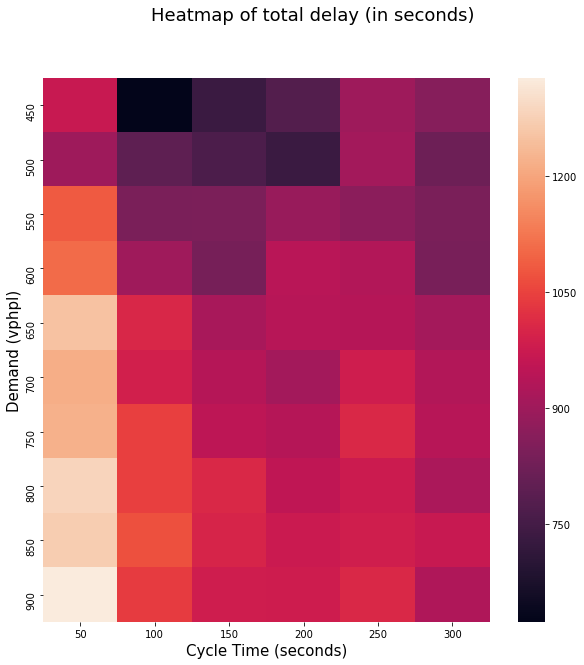

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data=df_delay_map, ax=ax)
ax.set_xlabel("Cycle Time (seconds)", fontsize=15)
ax.set_ylabel("Demand (vphpl)", fontsize=15)
fig.suptitle("Heatmap of total delay (in seconds)", fontsize=18)

Maybe the first cycle value is too high that it overshadows the others?

Text(0,0.5,'Delay (seconds)')

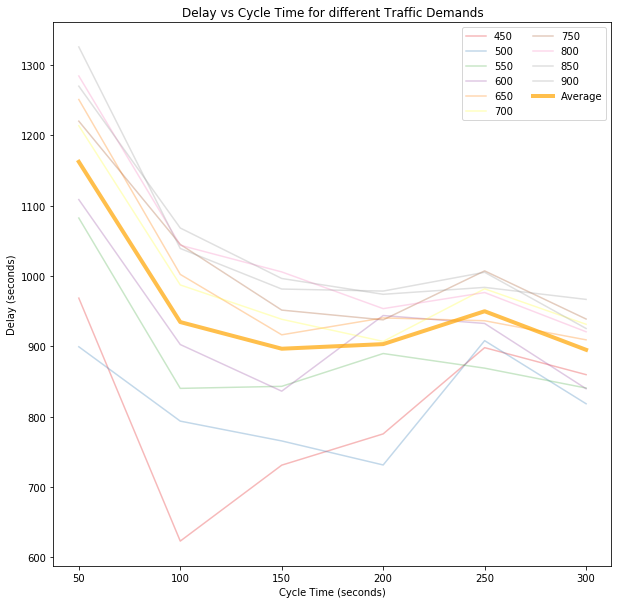

In [45]:
palette = plt.get_cmap('Set1')
df_delay_transpose = df_delay_map.transpose()
df_delay_avg = df_delay_transpose.mean(axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,10))

num=0
for column in df_delay_transpose:
    plt.plot(df_delay_transpose.index, df_delay_transpose[column], marker='', color=palette(num), linewidth=1.5, alpha=0.3, label=column)
    num+=1
    
plt.plot(df_delay_avg.index, df_delay_avg.values, marker='', color='orange', linewidth=4, alpha=0.7, label='Average')
    
# Add legend
plt.legend(loc=1, ncol=2)

# Add titles
plt.title("Delay vs Cycle Time for different Traffic Demands")
plt.xlabel("Cycle Time (seconds)")
plt.ylabel("Delay (seconds)")

## Visualizing how throughput changes

In [36]:
df_throughput_map = df_throughput.groupby(['demand', 'cycle']).agg({'throughput': 'sum'}).reset_index().pivot(index='demand', columns='cycle', values='throughput')
df_throughput_map

cycle,50,100,150,200,250,300
demand,,,,,,
450,954.0,968.0,1019.0,983.0,973.0,976.0
500,1019.0,1126.0,1096.0,1125.0,1075.0,1083.0
550,1021.0,1129.0,1131.0,1130.0,1111.0,1104.0
600,1076.0,1187.0,1200.0,1207.0,1193.0,1144.0
650,1077.0,1208.0,1233.0,1219.0,1248.0,1210.0
700,1096.0,1267.0,1283.0,1292.0,1279.0,1266.0
750,1142.0,1306.0,1320.0,1351.0,1383.0,1333.0
800,1142.0,1328.0,1381.0,1377.0,1416.0,1341.0
850,1220.0,1352.0,1401.0,1409.0,1403.0,1399.0


Text(0.5,0.98,'Heatmap of total throughput (in vehicles)')

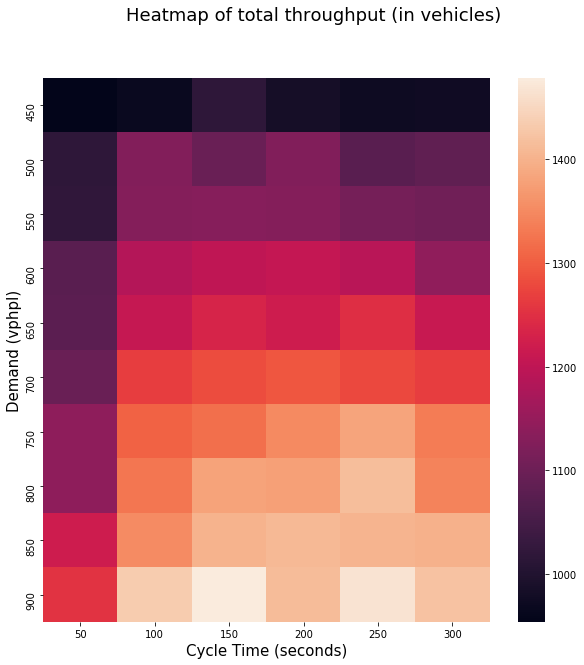

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data=df_throughput_map, ax=ax)
ax.set_xlabel("Cycle Time (seconds)", fontsize=15)
ax.set_ylabel("Demand (vphpl)", fontsize=15)
fig.suptitle("Heatmap of total throughput (in vehicles)", fontsize=18)

Text(0,0.5,'Throughput (vehicles)')

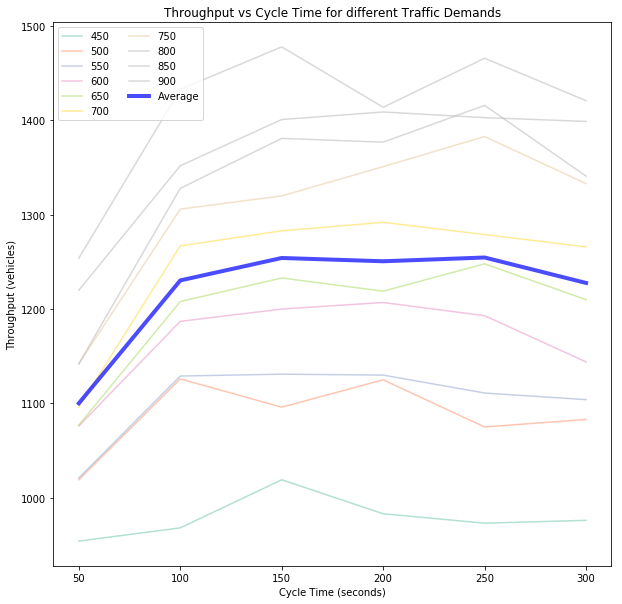

In [44]:
palette = plt.get_cmap('Set2')
df_throughput_transpose = df_throughput_map.transpose()
df_throughput_avg = df_throughput_transpose.mean(axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,10))

num=0
for column in df_throughput_transpose:
    plt.plot(df_throughput_transpose.index, df_throughput_transpose[column], marker='', color=palette(num), linewidth=1.5, alpha=0.5, label=column)
    num+=1
    
plt.plot(df_throughput_avg.index, df_throughput_avg.values, marker='', color='blue', linewidth=4, alpha=0.7, label='Average')

# Add legend
plt.legend(loc=2, ncol=2)

# Add titles
plt.title("Throughput vs Cycle Time for different Traffic Demands")
plt.xlabel("Cycle Time (seconds)")
plt.ylabel("Throughput (vehicles)")